# Anticipez les besoins en consommation électrique de bâtiments

# Nettoyage et exploration des données

* [Concaténation des bases de données](#Concaténation-des-bases-de-données)
* [Taux de données manquantes ](#Taux-de-données-manquantes )
* [Sélection de variables](#Sélection-de-variables)
* [Imputation des valeurs manquantes](#Imputation-des-valeurs-manquantes)
* [Nettoyage de données textuelles](#Nettoyage-de-données-textuelles)

In [247]:
pip install missingpy

Note: you may need to restart the kernel to use updated packages.


In [246]:
pip install asteval

  Preparing metadata (setup.py) ... done
  Created wheel for asteval: filename=asteval-0.9.25-py3-none-any.whl size=17287 sha256=51c7ca5c4064a743cf7bdb8651146cb5acad5dda581bb8a68862b4a65c1d6a55
  Stored in directory: /Users/mousta/Library/Caches/pip/wheels/9d/52/8e/9892a79fe41878280e133d5bd233a0d73dcab6f8dfd9a0e8cd
Successfully built asteval
Note: you may need to restart the kernel to use updated packages.


In [1086]:
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ast
from ast import literal_eval

from missingpy import MissForest
import timeit
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

from sklearn import model_selection
from sklearn import dummy
from sklearn import neighbors, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import kernel_ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

In [1169]:
data2015 = pd.read_csv("2015-building-energy-benchmarking.csv")
data2016 = pd.read_csv("2016-building-energy-benchmarking.csv")
pd.set_option('display.max_columns',100)

In [1088]:
print("La dataset de l'année 2015 compte {} observations et {} variables".format(data2015.shape[0],data2015.shape[1]))
print("The dataset of the year 2015 contains {} observations and {} variables".format(data2015.shape[0],data2015.shape[1]))
print("La dataset de l'année 2016 compte {} observations et {} variables".format(data2016.shape[0],data2016.shape[1]))
print("The dataset of the year 2016 contains {} observations and {} variables".format(data2016.shape[0],data2016.shape[1]))

La dataset de l'année 2015 compte 3340 observations et 47 variables
The dataset of the year 2015 contains 3340 observations and 47 variables
La dataset de l'année 2016 compte 3376 observations et 46 variables
The dataset of the year 2016 contains 3376 observations and 46 variables


In [1166]:
print("Les variables collectées en 2015 et non pas en 2016 sont les suivantes:")
for column in data2015:
    if column not in data2016:
        print("-{}".format(column))

Les variables collectées en 2015 et non pas en 2016 sont les suivantes:
-OtherFuelUse(kBtu)
-2010 Census Tracts
-Seattle Police Department Micro Community Policing Plan Areas
-City Council Districts
-SPD Beats


In [1090]:
print("Les variables collectées en 2016 et non pas en 2015 sont les suivantes:")
for column in data2016:
    if column not in data2015 :
        print("-{}".format(column))

Les variables collectées en 2016 et non pas en 2015 sont les suivantes:
-Address
-City
-State
-ZipCode
-Latitude
-Longitude
-Comments
-TotalGHGEmissions
-GHGEmissionsIntensity


### Concaténation des bases de données

<AxesSubplot:>

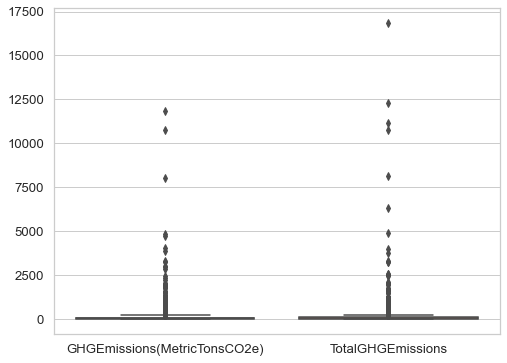

In [1184]:
GHGEmissions =  pd.DataFrame([data2015['GHGEmissions(MetricTonsCO2e)'],data2016['TotalGHGEmissions']]).T
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.figure(figsize=(8,6))
sns.boxplot(data=GHGEmissions)

- Il s'avère que les données de la variable **TotalGHGEmissions** receuilli en 2016 et la variable **GHGEmissions(MetricTonsCO2e)** receulli en 2015 suivent la même distribution donc ces 2 variables sont similaires

<AxesSubplot:>

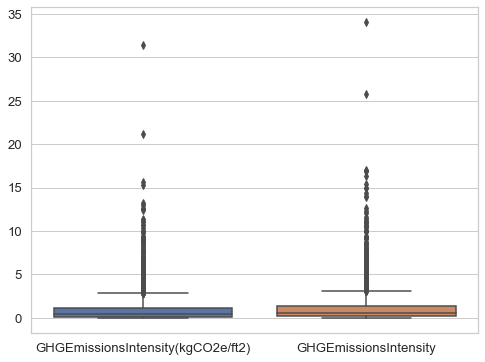

In [1185]:
GHGEintensity =  pd.DataFrame([data2015['GHGEmissionsIntensity(kgCO2e/ft2)'],data2016['GHGEmissionsIntensity']]).T
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.figure(figsize=(8,6))
sns.boxplot(data=GHGEintensity)

- De la même façon, il s'avère que les données de la variable **GHGEmissionsIntensity** receuilli en 2016 et la variable **GHGEmissionsIntensity(kgCO2e/ft2)** receulli en 2015 suivent la même distribution donc ces 2 variables sont similaires 

On remarque que la variable **Location** de la database de 2015 contient un dictionnaire avec les informations suivantes : latitude, longitude, address, city, state, zip.
Je vais scinder ce dictionnaire pour pouvoir extraire les informations et les integrer dans la database 2015 en créant de nouvelles colonnes pour chacune. Pour faire je vais utiliser `ast.literal_eval`qui permet d'évaluez en toute sécurité un noeud d'expression ou une chaîne contenant un Python littéral de type chaînes, octets, nombres, tuples, listes, plans, ensembles, booléens, Aucun, octets et ensembles. ou un affichage de conteneur.

In [1186]:
data2015.Location = data2015.Location.apply(literal_eval)
Location1 = data2015['Location'].apply(pd.Series)
Location1.human_address = Location1.human_address.apply(literal_eval)
Location2 = Location1.human_address.apply(pd.Series)

In [1187]:
Coordonnées = Location1[["latitude","longitude"]]
extracted_location = pd.concat([Coordonnées,Location2],axis=1)

In [1188]:
data2015 = pd.concat([data2015,extracted_location],axis=1) # intégration des données extraites de la colonne Location à la database 2015

In [1189]:
data2015.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,latitude,longitude,address,city,state,zip
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,WA,98101
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081,47.61310583,-122.33335756,724 PINE ST,SEATTLE,WA,98101
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,WA,98101


In [1192]:
data2015[["Zip Codes","zip"]].head(5)

,Zip Codes,zip
0,18081,98101
1,18081,98101
2,18081,98101
3,18081,98101
4,19576,98121


- On remarque que la colonne Zip Codes contient des codes postales qui ne correspondent pas au code postal de la ville de Seattle qui possède des zipcodes entre 98101 et 98199 donc cette colonne va etre supprimée.

Je vais maintenant vérifier que les variables similaires dans la database de 2015 et 2016 sont écrites de la même façon:

In [1097]:
data2015 = data2015.rename(columns={'GHGEmissionsIntensity(kgCO2e/ft2)' : 'GHGEmissionsIntensity',\
                                    'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',\
                                    'Comment':'Comments', 'zip':'ZipCode', 'latitude':'Latitude',\
                                    'longitude':'Longitude','address':'Address',\
                                    'city':'City','state':'State'})

In [1098]:
data2015 = data2015.drop(["Location", "Zip Codes"], axis=1) 
#suppréssion de la colonne Location dont on nous avons procédé à l'extraction des données qu'elle contienne et la variable Zip Codes qui ne contient pas les codes postales de Seattle

- Je vais concatener les 2 datasets pour créer une seule dataset avec `pd.concat`

In [1099]:
new_data = pd.concat([data2015,data2016],ignore_index=True,sort=False) #La nouvelle dataset est nommée new_data

In [1100]:
print("La nouvelle dataset *new_data* compte {} observations et {} variables".format(new_data.shape[0],new_data.shape[1]))

La nouvelle dataset *new_data* compte 6716 observations et 51 variables


Maintenant, je vais appliquer la méthode `drop_duplicates()` à la dataframe afin de supprimer d'éventuelles doublons exactes

In [1101]:
new_data = new_data.drop_duplicates().reset_index(drop=True)

In [1102]:
print("La nouvelle dataset *new_data* compte {} observations et {} variables".format(new_data.shape[0],new_data.shape[1]))

La nouvelle dataset *new_data* compte 6716 observations et 51 variables


Il n'existe pas de lignes dupliquées dans la dataframe

In [1103]:
type = pd.DataFrame(new_data.dtypes,columns=["type"])
type["type"].value_counts()

float64    24
object     20
int64       7
Name: type, dtype: int64

In [1104]:
new_data.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Latitude,Longitude,Address,City,State,ZipCode
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,WA,98101
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,47.61310583,-122.33335756,724 PINE ST,SEATTLE,WA,98101
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.0,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,WA,98101


- Notre équipe s’intéresse de près aux émissions des bâtiments non destinés à l’habitation. Donc je vais appliquer un filtre pour récupérer seulement les observations correspondantes aux bâtiments non destinés à l’habitation.

In [1193]:
data_NR = new_data[new_data["BuildingType"].str.contains("NonResidential|Nonresidential COS|Nonresidential WA")]
print("Après la supression des observations correspondantes aux batiments destinées à l'habitation,\
la dataframe compte {} observations et {} variables".format(data_NR.shape[0],data_NR.shape[1]))

Après la supression des observations correspondantes aux batiments destinées à l'habitation,la dataframe compte 3075 observations et 51 variables


### Taux de données manquantes 

Text(0.5, 1.0, 'Taux de données manquantes')

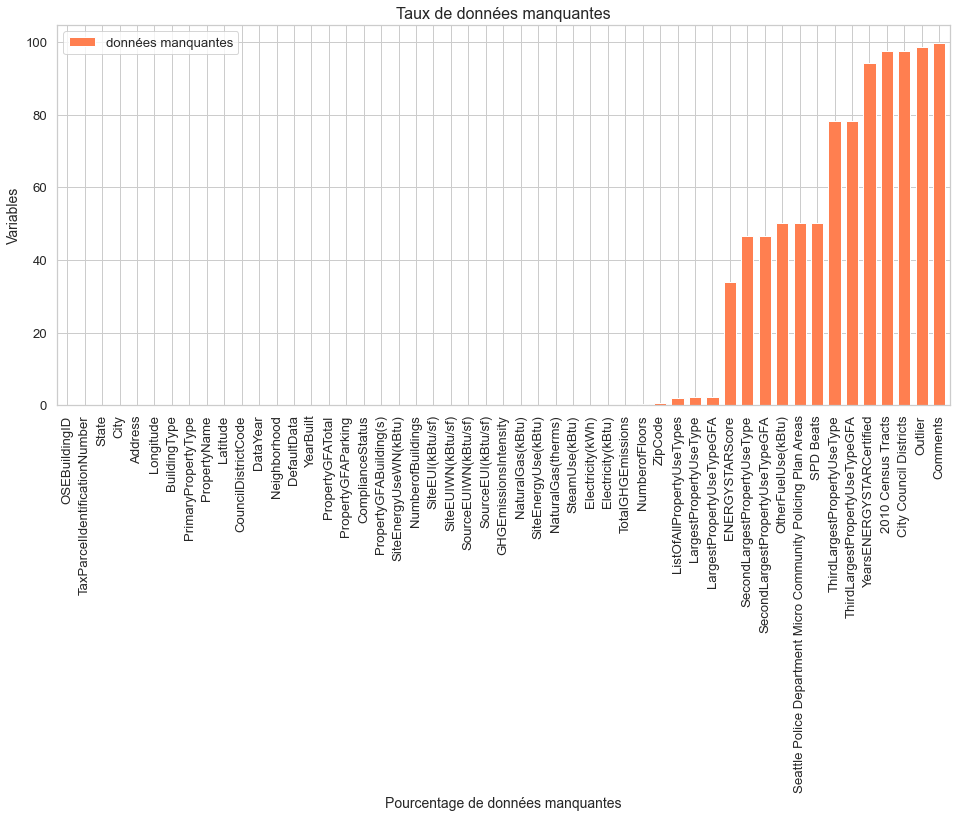

In [1106]:
missing_data = round(data_NR.isna().sum()*100/len(data_NR),1)
missing_data = pd.DataFrame(missing_data.reset_index())
missing_data.columns=["variable","données manquantes"]
missing_data = missing_data.sort_values(by="données manquantes",ascending=False)
missing_data1 = missing_data
fig = missing_data1.sort_values(by="données manquantes",ascending=True).plot.bar(x="variable", y="données manquantes",figsize=(16,7),color="coral",width=0.7)
plt.xlabel('Pourcentage de données manquantes',fontsize=14)
plt.ylabel('Variables', fontsize=14)
fig.set_title("Taux de données manquantes",fontsize=16) 

In [1107]:
missing_new_data_50p = missing_new_data[missing_new_data["données manquantes"].between(0,50)]
missing_new_data_50p.shape
print("{}/{} variables contiennent entre 0 et 50% de valeurs manquantes".format(missing_new_data_50p.shape[0],new_data.shape[1]))

39/51 variables contiennent entre 0 et 50% de valeurs manquantes


In [1108]:
missing_new_data_100p = missing_new_data[missing_new_data["données manquantes"].between(50,100)]
missing_new_data_100p.shape
print("{}/{} variables contiennent entre 50 et 100% de valeurs manquantes".format(missing_new_data_100p.shape[0],new_data.shape[1]))

12/51 variables contiennent entre 50 et 100% de valeurs manquantes


In [1109]:
missing_new_data_60p = missing_new_data[missing_new_data["données manquantes"] >60]
missing_new_data_60p.shape
print("{}/{} variables contiennent plus de 60% de valeurs manquantes".format(missing_new_data_60p.shape[0],new_data.shape[1]))

7/51 variables contiennent plus de 60% de valeurs manquantes


### Sélection de variables

- Les données déclaratives suivantes sont séléctionnées pour faire la prédiction des émissions totales de CO2 **`TotalGHGEmissions`** et de consommations totales d'énergie **`SiteEnergyUseWN(kBtu)`** : `PrimaryPropertyType`, `Neighborhood`, `YearBuilt`, `NumberofBuildings`, `NumberofFloors`, `PropertyGFATotal`, `PropertyGFABuilding(s)`,`LargestPropertyUseType`,`LargestPropertyUseTypeGFA`,`ENERGYSTARScore`,`ZipCode`.   

- Certaines de ces variables présentes un taux très faible de données manquantes < 2.5% (exemple : `LargestPropertyUseType` et `ZipCode`. Les quelques observations manquantes vont etre supprimés pour ces variables. 

In [1110]:
missing_data.iloc[12]

variable              ENERGYSTARScore
données manquantes               34.0
Name: 22, dtype: object

- La variable `ENERGYSTARScore` présente un taux de données manqantes = 34%, les valeurs manquantes de cette variables seront imputées avec l'algorithme `MissForest`. 

In [1111]:
variables = ["PrimaryPropertyType", "Neighborhood", "YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseType","LargestPropertyUseTypeGFA","ZipCode","TotalGHGEmissions","SiteEnergyUseWN(kBtu)"]

In [1112]:
data_pred = data_NR[variables]
data_pred = pd.concat([data_pred,data_NR["ENERGYSTARScore"]],axis=1)
data_pred = data_pred.dropna(subset=["PrimaryPropertyType", "Neighborhood", "YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseType","LargestPropertyUseTypeGFA","ZipCode","TotalGHGEmissions","SiteEnergyUseWN(kBtu)"])

In [1113]:
data_pred.head(3)

,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ZipCode,TotalGHGEmissions,SiteEnergyUseWN(kBtu),ENERGYSTARScore
0,Hotel,DOWNTOWN,1927,1.0,12.0,88434,88434,Hotel,88434.0,98101,249.43,7097539.0,65.0
1,Hotel,DOWNTOWN,1996,1.0,11.0,103566,88502,Hotel,83880.0,98101,263.51,8765788.0,51.0
2,Hotel,DOWNTOWN,1969,1.0,41.0,961990,961990,Hotel,757243.0,98101,2061.48,75506272.0,18.0


In [1114]:
print("La dataframe compte maintenant {} observations et {} variables".format(data_pred.shape[0],data_pred.shape[1]))

La dataframe compte maintenant 2983 observations et 13 variables


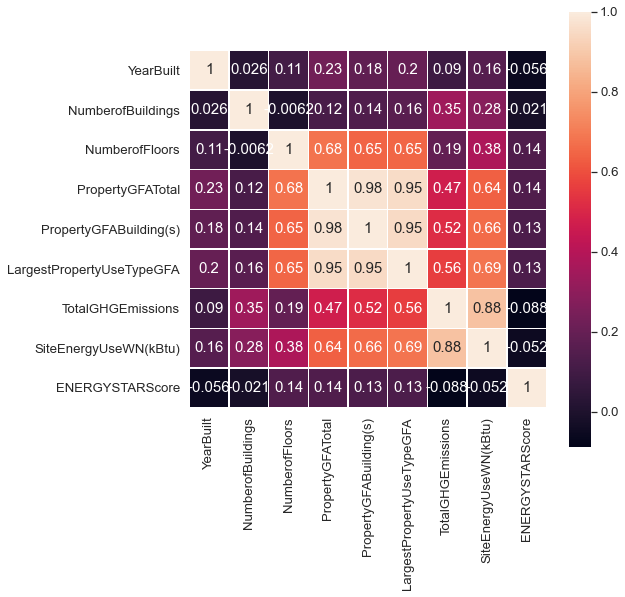

In [1115]:
variables_quantitatives = ["PrimaryPropertyType", "Neighborhood", "YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseType","LargestPropertyUseTypeGFA","ZipCode","TotalGHGEmissions","SiteEnergyUseWN(kBtu)","ENERGYSTARScore"]
plt.figure(figsize=(8, 8))
sns.heatmap(data_pred[variables_quantitatives].corr(), annot=True, square=True, linewidths=.5, annot_kws={"size":15})
plt.show()

- On remarque que les variables `PropertyGFATotal`, `PropertyGFABuilding(s)`, `LargestPropertyUseTypeGFA` sont très corrélés donc seulement la variable `PropertyGFATotal`va être retenu pour notre modèle.

In [1116]:
variables2 = ["PrimaryPropertyType", "Neighborhood", "YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal","ZipCode","TotalGHGEmissions","SiteEnergyUseWN(kBtu)"]
data_pred = data_NR[variables2]
data_pred = pd.concat([data_pred,data_NR["ENERGYSTARScore"]],axis=1)
data_pred = data_pred.dropna(subset=["PrimaryPropertyType", "Neighborhood", "YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal","ZipCode","TotalGHGEmissions","SiteEnergyUseWN(kBtu)"])

In [1117]:
print("La dataframe finale qui va être utilisée pour les modèles de prédiction compte \nmaintenant {} observations et {} variables".format(data_pred.shape[0],data_pred.shape[1]))

La dataframe finale qui va être utilisée pour les modèles de prédiction compte 
maintenant 3048 observations et 10 variables


### Imputation des valeurs manquantes

- Je vais maintenant utiliser l'algorithme `MissForest` pour imputer les valeurs manquantes de la variable `ENERGYSTARScore` en utilisant les variables numériques (continues et discrètes).

In [1118]:
variables_numériques = ["YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal","ZipCode","TotalGHGEmissions","SiteEnergyUseWN(kBtu)","ENERGYSTARScore"]
data_impute_ENERGYSTARScore = data_pred[variables_numériques]
imputer = MissForest(criterion='squared_error',random_state=42)
data_pred_filled = pd.DataFrame(imputer.fit_transform(data_impute_ENERGYSTARScore))

Iteration: 0
Iteration: 1
Iteration: 2


In [1119]:
data_pred_filled.columns = ["YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal","ZipCode","TotalGHGEmissions","SiteEnergyUseWN(kBtu)","ENERGYSTARScore"]

In [1120]:
data_pred_qualitatives = data_pred[["PrimaryPropertyType", "Neighborhood"]].reset_index(drop=True)
data_pred_final = pd.concat([data_pred_qualitatives,data_pred_filled],axis=1)

In [1121]:
missing_data_pred = round(data_pred_final.isna().sum()*100/len(data_pred_final),1)

In [1122]:
missing_data_pred

PrimaryPropertyType      0.0
Neighborhood             0.0
YearBuilt                0.0
NumberofBuildings        0.0
NumberofFloors           0.0
PropertyGFATotal         0.0
ZipCode                  0.0
TotalGHGEmissions        0.0
SiteEnergyUseWN(kBtu)    0.0
ENERGYSTARScore          0.0
dtype: float64

### Nettoyage de données textuelles 

Je vais regrouper tout les valeurs de la variable `PrimaryPropertyType` qui correspondent au même type :

In [1123]:
data_pred_final["PrimaryPropertyType"].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'College/University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility\n',
       'Distribution Center', 'K-12 School', 'Large Office',
       'Retail Store', 'Senior Care Community', 'Medical Office',
       'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Distribution Center\n',
       'Worship Facility', 'Supermarket/Grocery Store', 'Laboratory',
       'Self-Storage Facility', 'Refrigerated Warehouse', 'Restaurant\n',
       'Low-Rise Multifamily', 'Restaurant', 'University', 'Warehouse',
       'Residence Hall', 'Supermarket / Grocery Store'], dtype=object)

In [1124]:
data_pred_final = data_pred_final.replace(to_replace =["University","K-12 School","College/University"],value ="School/College/University")
data_pred_final = data_pred_final.replace(to_replace =["Small- and Mid-Sized Office","Large Office","Medical Office"],value ="Office")
data_pred_final = data_pred_final.replace(to_replace =["Non-Refrigerated Warehouse","Refrigerated Warehouse","Warehouse"],value ="Warehouse")
data_pred_final = data_pred_final.replace(to_replace =["Supermarket / Grocery Store"],value ="Supermarket/Grocery Store")
data_pred_final = data_pred_final.replace(to_replace =["Self-Storage Facility\n"],value ="Self-Storage Facility")
data_pred_final = data_pred_final.replace(to_replace =["Restaurant\n"],value ="Restaurant")
data_pred_final = data_pred_final.replace(to_replace =["Residence Hall"],value ="Residence Hall/Dormitory")
data_pred_final = data_pred_final.replace(to_replace =["Distribution Center\n"],value ="Distribution Center")

In [1125]:
data_pred_final["PrimaryPropertyType"].unique()

array(['Hotel', 'Other', 'Mixed Use Property',
       'School/College/University', 'Office', 'Self-Storage Facility',
       'Distribution Center', 'Retail Store', 'Senior Care Community',
       'Hospital', 'Residence Hall/Dormitory', 'Warehouse',
       'Worship Facility', 'Supermarket/Grocery Store', 'Laboratory',
       'Restaurant', 'Low-Rise Multifamily'], dtype=object)

Je fais la même chose pour la variable `Neighborhood` : 

In [1126]:
data_pred_final["Neighborhood"].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'MAGNOLIA / QUEEN ANNE', 'CENTRAL',
       'SOUTHWEST', 'SOUTHEAST', 'NORTH', 'DELRIDGE', 'North', 'Delridge',
       'Ballard', 'Northwest', 'Central'], dtype=object)

In [1127]:
data_pred_final = data_pred_final.replace(to_replace =["Delridge"],value ="DELRIDGE")
data_pred_final = data_pred_final.replace(to_replace =["North"],value ="NORTH")
data_pred_final = data_pred_final.replace(to_replace =["Northwest"],value ="NORTHWEST")
data_pred_final = data_pred_final.replace(to_replace =["Ballard"],value ="BALLARD")
data_pred_final = data_pred_final.replace(to_replace =["Central"],value ="CENTRAL")

In [1128]:
data_pred_final["Neighborhood"].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'MAGNOLIA / QUEEN ANNE', 'CENTRAL',
       'SOUTHWEST', 'SOUTHEAST', 'NORTH', 'DELRIDGE'], dtype=object)

In [1129]:
data_pred_final.head(3)

,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ZipCode,TotalGHGEmissions,SiteEnergyUseWN(kBtu),ENERGYSTARScore
0,Hotel,DOWNTOWN,1927.0,1.0,12.0,88434.0,98101.0,249.43,7097539.0,65.0
1,Hotel,DOWNTOWN,1996.0,1.0,11.0,103566.0,98101.0,263.51,8765788.0,51.0
2,Hotel,DOWNTOWN,1969.0,1.0,41.0,961990.0,98101.0,2061.48,75506272.0,18.0


In [1130]:
data_pred_final.YearBuilt = data_pred_final.YearBuilt.astype(int)
data_pred_final.NumberofBuildings = data_pred_final.NumberofBuildings.astype(int)
data_pred_final.NumberofFloors = data_pred_final.NumberofFloors.astype(int)
data_pred_final.ZipCode = data_pred_final.ZipCode.astype(int)

In [1131]:
years_built = data_pred_final["YearBuilt"].sort_values().unique()
print(years_built)

[1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913
 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927
 1928 1929 1930 1931 1932 1935 1936 1937 1938 1939 1940 1941 1942 1944
 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958
 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972
 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986
 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015]


- On remarque que les années de constructions sont répartis entre l'année 1900 et 2015, afin de faciliter l'interprétation de l'année de construction et son impact sur les émissions/consommations, je vais diviser les années de construction par décennie.

In [1136]:
data_pred_final.head(3)

,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ZipCode,TotalGHGEmissions,SiteEnergyUseWN(kBtu),ENERGYSTARScore
0,Hotel,DOWNTOWN,1921-1930,1,12,88434.0,98101,249.43,7097539.0,65.0
1,Hotel,DOWNTOWN,1991-2000,1,11,103566.0,98101,263.51,8765788.0,51.0
2,Hotel,DOWNTOWN,1961-1970,1,41,961990.0,98101,2061.48,75506272.0,18.0


In [1155]:
data_pred_final.YearBuilt = data_pred_final.YearBuilt.apply(str)
data_pred_final.ZipCode = data_pred_final.ZipCode.astype(str)

In [1134]:
data_pred_final.loc[(data_pred_final.YearBuilt >= "1900") & (data_pred_final.YearBuilt <= "1910"), "YearBuilt"] = "1900-1910"
data_pred_final.loc[(data_pred_final.YearBuilt >= "1911") & (data_pred_final.YearBuilt <= "1920"), "YearBuilt"] = "1911-1920"
data_pred_final.loc[(data_pred_final.YearBuilt >= "1921") & (data_pred_final.YearBuilt <= "1930"), "YearBuilt"] = "1921-1930"
data_pred_final.loc[(data_pred_final.YearBuilt >= "1931") & (data_pred_final.YearBuilt <= "1940"), "YearBuilt"] = "1931-1940"
data_pred_final.loc[(data_pred_final.YearBuilt >= "1941") & (data_pred_final.YearBuilt <= "1950"), "YearBuilt"] = "1941-1950"
data_pred_final.loc[(data_pred_final.YearBuilt >= "1951") & (data_pred_final.YearBuilt <= "1960"), "YearBuilt"] = "1951-1960"
data_pred_final.loc[(data_pred_final.YearBuilt >= "1961") & (data_pred_final.YearBuilt <= "1970"), "YearBuilt"] = "1961-1970"
data_pred_final.loc[(data_pred_final.YearBuilt >= "1971") & (data_pred_final.YearBuilt <= "1980"), "YearBuilt"] = "1971-1980"
data_pred_final.loc[(data_pred_final.YearBuilt >= "1981") & (data_pred_final.YearBuilt <= "1990"), "YearBuilt"] = "1981-1990"
data_pred_final.loc[(data_pred_final.YearBuilt >= "1991") & (data_pred_final.YearBuilt <= "2000"), "YearBuilt"] = "1991-2000"
data_pred_final.loc[(data_pred_final.YearBuilt >= "2001") & (data_pred_final.YearBuilt <= "2010"), "YearBuilt"] = "2001-2010"
data_pred_final.loc[(data_pred_final.YearBuilt >= "2011") & (data_pred_final.YearBuilt <= "2020"), "YearBuilt"] = "2011-2020"
data_pred_final.loc[(data_pred_final.YearBuilt >= "2021") & (data_pred_final.YearBuilt <= "2030"), "YearBuilt"] = "2021-2030"

In [1157]:
data_pred_final.describe()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,TotalGHGEmissions,SiteEnergyUseWN(kBtu),ENERGYSTARScore
count,3048.000000,3048.00000,3.048000e+03,3048.000000,3.048000e+03,3048.000000
mean,1.022966,4.30643,1.117135e+05,164.325997,7.763053e+06,61.057277
std,0.431144,6.80503,1.913929e+05,566.067756,1.882415e+07,26.591079
min,0.000000,0.00000,1.630000e+04,-0.800000,0.000000e+00,1.000000
25%,1.000000,1.00000,2.881700e+04,18.997500,1.281681e+06,42.320000
50%,1.000000,2.00000,4.768600e+04,47.595000,2.713462e+06,64.985000
75%,1.000000,4.00000,1.029300e+05,135.552500,7.195354e+06,83.000000
max,9.000000,99.00000,1.952220e+06,12307.160000,2.977410e+08,100.000000


In [1163]:
data_pred_final.to_csv("Seattle_table")